# ***Aashray Anand***
## Introduction to Random Forests: Titanic Data Set

to get practice with kaggle competitions, and the random forest ML model, 
will be making predictions for the "getting started" titanic data set competition

12/17/2018, 2:27 AM

In [53]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
# import fastai libraries
#from fastai.imports import *
#from fastai.structured import *

#from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [55]:
PATH = 'data/'

In [56]:
!ls {PATH}

gender_submission.csv test.csv              train.csv


In [57]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#import pydot
import re

import numpy as np
import scipy as sc
import sklearn
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv(f'{PATH}train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [58]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [59]:
def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [60]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 1. Exploratory Data Analysis

In [61]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### This data set contains 891 entries, most of the columns in the data set are numerical, however, we will need to convert the Name/Sex/Ticket/Cabin/Embarked columns to numerical data types to train a model, or remove some of these columns ###

In [63]:
display_all(df.isnull().sum().sort_values(ascending=False)/len(df))

Cabin          0.771044
Age            0.198653
Embarked       0.002245
Fare           0.000000
Ticket         0.000000
Parch          0.000000
SibSp          0.000000
Sex            0.000000
Name           0.000000
Pclass         0.000000
Survived       0.000000
PassengerId    0.000000
dtype: float64

### the cabin column has too many missing values to be a useful column, we can remove this, we will also need to determine an effective way to fill in missing age values ###

In [64]:
def plot_columns_versus_y(df, y):
    for column in df.columns:
        if np.issubdtype(df[column].dtype, np.number):
        #if is_numeric_dtype(df[column]):
            plt.scatter(df[column], df[y])
            plt.xlabel(column)
            plt.ylabel(y)
            plt.show()

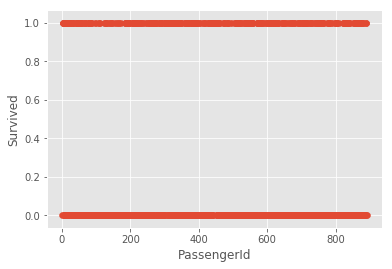

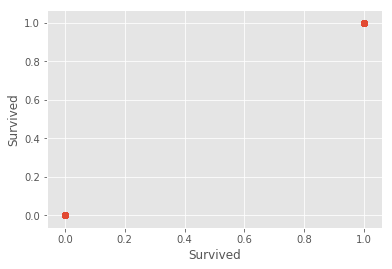

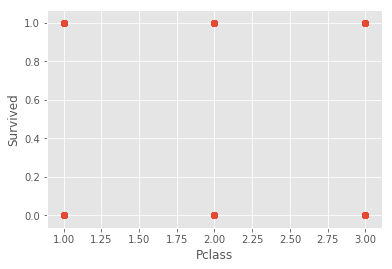

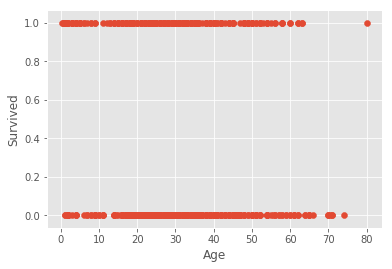

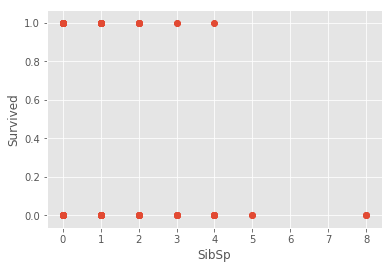

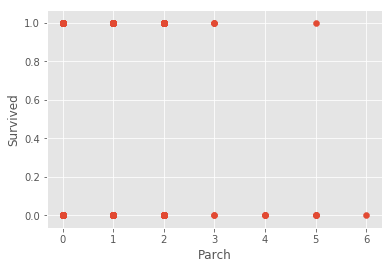

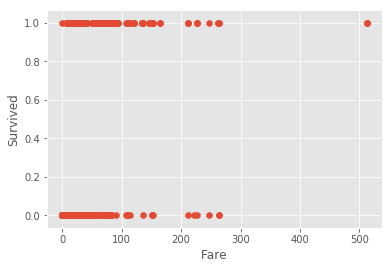

In [65]:
plot_columns_versus_y(df, 'Survived')

In [66]:
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

### Let's plot some histograms of each column (excluding ID) to see the distribution of values

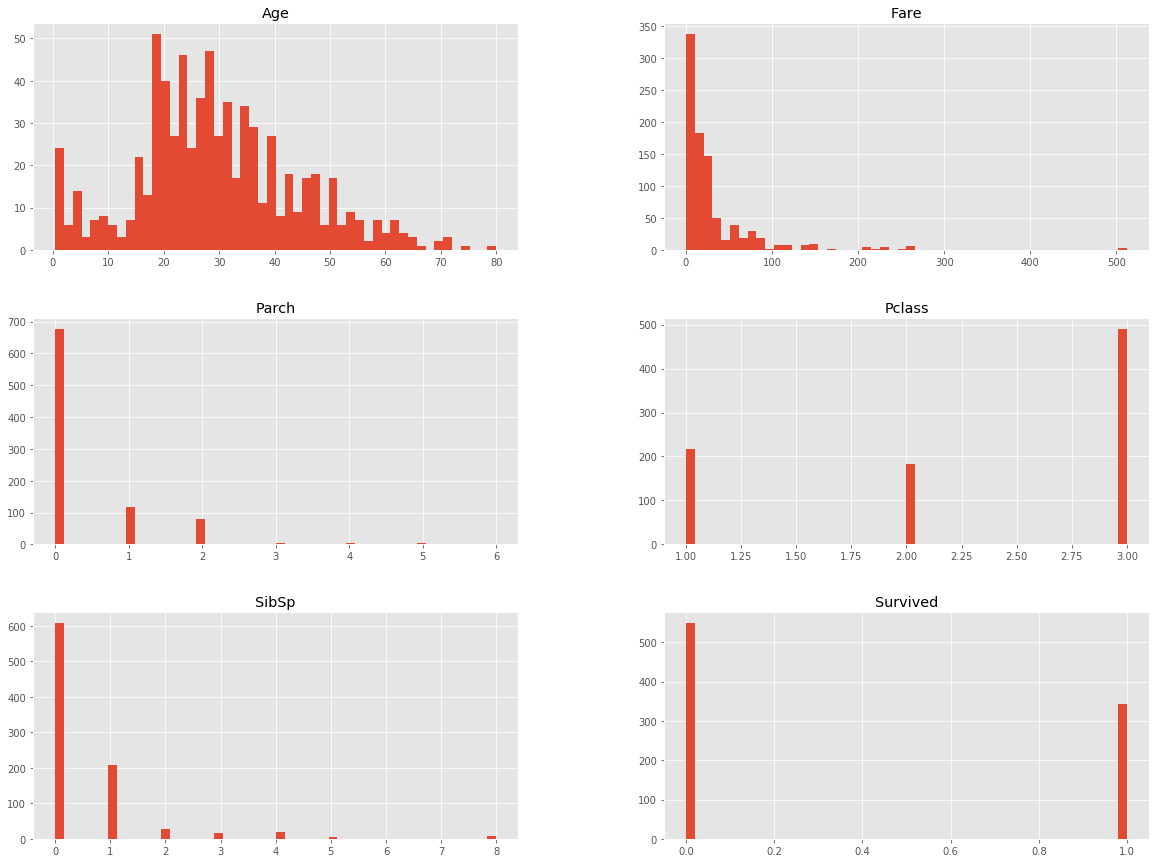

In [67]:
df.drop(['PassengerId'], 1).hist(bins=50, figsize=(20,15))
plt.show()

### from the above histograms, we can conclude the following: ###
* about 35% of passengers survived
* most of the passengers were alone
* most of the passengers were in 3rd class
* most of the fares were below $500

# 2. Feature Engineering

In [68]:
def process_df(df):
    processed_df = df
    # remove ID and ticket, irrelevant to survival of passenger
    processed_df.drop(['PassengerId', 'Ticket', 'Name', 'Cabin'], axis=1, inplace=True)
    # replace missing embarked values with most common embarked value
    processed_df['Embarked'].fillna('S', inplace=True)
    # replace missing age values with mean age
    processed_df['Age'].fillna(processed_df['Age'].mean(), inplace=True)
    # change age values to integers
    processed_df['Age'] = processed_df['Age'].astype(int)
    #processed_df['Cabin'].fillna('U0', inplace=True)
    processed_df['Fare'].fillna(processed_df['Fare'].mean(), inplace=True)
    # map gender column to numerical values
    gender = {'male': 0, 'female': 1}
    embarked = {'S' : 0, 'C': 1, 'Q': 2}
    processed_df['Sex'] = [gender[row] for row in processed_df['Sex']]
    processed_df['Embarked'] = [embarked[row] for row in processed_df['Embarked']]
    # create family column, to represent sum of siblings column and parents/children column
    processed_df['Family'] = processed_df['SibSp'] + processed_df['Parch']
    return processed_df

In [69]:
processed_df = process_df(df)

In [70]:
processed_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family
0,0,3,0,22,1,0,7.2500,0,1
1,1,1,1,38,1,0,71.2833,1,1
2,1,3,1,26,0,0,7.9250,0,0
3,1,1,1,35,1,0,53.1000,0,1
4,0,3,0,35,0,0,8.0500,0,0


In [71]:
def split_variables(df, y_variable):
    # given a specified variable from a data frame to predict
    # return the data frame of other variables, and this variable
    # separated as X and y
    y = df[y_variable]
    return df.drop(y_variable, axis=1), y

In [72]:
X, y = split_variables(processed_df, 'Survived')

In [73]:
# create a train set and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [74]:
m = RandomForestClassifier()
m.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [75]:
y_pred = m.predict(X_test)

In [76]:
metrics.accuracy_score(y_test, y_pred)

0.8100558659217877

In [77]:
df_test = pd.read_csv(f'{PATH}test.csv')

In [78]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [79]:
processed_df.groupby(['Survived','Sex'])['Survived'].count()

Survived  Sex
0         0      468
          1       81
1         0      109
          1      233
Name: Survived, dtype: int64

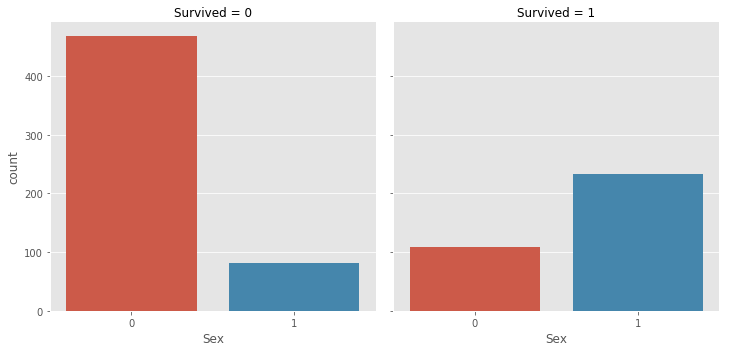

In [80]:
sns.catplot(x='Sex', col='Survived', kind='count', data=processed_df)

In [81]:
male_survival_rate = processed_df.Survived[processed_df.Sex == 0].sum() / processed_df[processed_df.Sex == 0].Survived.count()
female_survival_rate = processed_df.Survived[processed_df.Sex == 1].sum() / processed_df[processed_df.Sex == 1].Survived.count()
print(male_survival_rate * 100, "% of men survived")
print(female_survival_rate * 100, "% of women survived")

18.890814558058924 % of men survived
74.20382165605095 % of women survived


### from the above grouping (where male=0, female=1), we see that the rate of survival for women was much higher than that of men

In [82]:
processed_df.groupby(['Survived','Pclass'])['Survived'].count()

Survived  Pclass
0         1          80
          2          97
          3         372
1         1         136
          2          87
          3         119
Name: Survived, dtype: int64

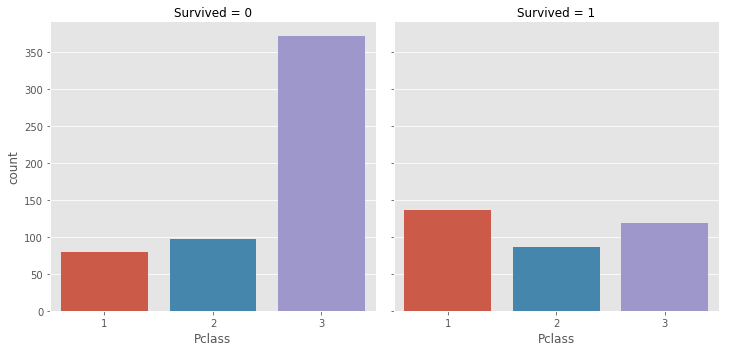

In [83]:
sns.catplot(x='Pclass', col='Survived', kind='count', data=processed_df)

In [84]:
class_1_survival = processed_df.Survived[processed_df.Pclass == 1].sum() / processed_df[processed_df.Pclass == 1].Survived.count()
class_2_survival = processed_df.Survived[processed_df.Pclass == 2].sum() / processed_df[processed_df.Pclass == 2].Survived.count()
class_3_survival = processed_df.Survived[processed_df.Pclass == 3].sum() / processed_df[processed_df.Pclass == 3].Survived.count()
print(class_1_survival * 100, "% of people in 1st pclass survived")
print(class_2_survival * 100, "% of people in 2nd pclass survived")
print(class_3_survival * 100, "% of people in 3rd pclass survived")

62.96296296296296 % of people in 1st pclass survived
47.28260869565217 % of people in 2nd pclass survived
24.236252545824847 % of people in 3rd pclass survived


### from the above grouping, we see that the rate of survival significantly higher for upper class passengers than lower class passengers

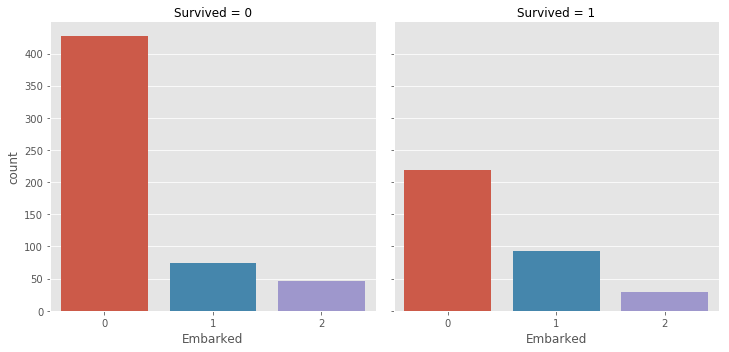

In [85]:
sns.catplot(x='Embarked', col='Survived', kind='count', data=processed_df)

In [90]:
embarked_S_survival = processed_df.Survived[processed_df.Embarked == 0].sum() / processed_df[processed_df.Embarked == 0].Survived.count()
embarked_C_survival = processed_df.Survived[processed_df.Embarked == 1].sum() / processed_df[processed_df.Embarked == 1].Survived.count()
embarked_Q_survival = processed_df.Survived[processed_df.Embarked == 2].sum() / processed_df[processed_df.Embarked == 2].Survived.count()
print(embarked_S_survival * 100, "% of people who embarked at S survived")
print(embarked_C_survival * 100, "% of people who embarked at C survived")
print(embarked_Q_survival * 100, "% of people who embarked at Q survived")

33.90092879256966 % of people who embarked at S survived
55.35714285714286 % of people who embarked at C survived
38.961038961038966 % of people who embarked at Q survived


In [91]:
processed_df.count()

Survived    891
Pclass      891
Sex         891
Age         891
SibSp       891
Parch       891
Fare        891
Embarked    891
Family      891
dtype: int64

In [92]:
results = pd.DataFrame()
results['PassengerId'] = df_test['PassengerId']
processed_df_test = process_df(df_test)
processed_df_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family
0,3,0,34,0,0,7.8292,2,0
1,3,1,47,1,0,7.0000,0,1
2,2,0,62,0,0,9.6875,2,0
3,3,0,27,0,0,8.6625,0,0
4,3,1,22,1,1,12.2875,0,2
5,3,0,14,0,0,9.2250,0,0
6,3,1,30,0,0,7.6292,2,0
7,2,0,26,1,1,29.0000,0,2
8,3,1,18,0,0,7.2292,1,0
9,3,0,21,2,0,24.1500,0,2


In [93]:
j = RandomForestClassifier()
j.fit(X_train, y_train)
y_pred = j.predict(processed_df_test)

In [96]:
results['Survived'] = y_pred
try:
    results.to_csv('results.csv', index=False)
    print("results stored in results.csv successfully")
except:
    print("predictions failed to save")

results stored in results.csv successfully
